<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/Feature_Extraction_Baseline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Gyanendar Manohar

Description: Implementation of feature extatction based CNN

B. Al-Bander, W. Al-Nuaimy, M. A. Al-Taee, and Y. Zheng, “Automated glau-
coma diagnosis using deep learning approach,” in 2017 14th International Multi-
Conference on Systems, Signals & Devices (SSD). IEEE, 2017, pp. 207–210

In [ ]:
import gc
import os
import cv2
import random
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Activation
from IPython.display import display
#from keras.utils import plot_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def set_seed(seed = 100):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [ ]:
# Returns high level model object based on model name
# List model considerd for this experiment 
# vgg16,vgg19,resnet50
# densenet121,densenet169
#
def get_high_level_model(trained_model_name,inputshape):

  if trained_model_name == "vgg16":
      return tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "vgg19":
      return tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "resnet50":
     return tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "densenet121":
     return tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "densenet169":
     return tf.keras.applications.DenseNet169(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "InceptionV3":
     return tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_shape = inputshape)  
     
  elif trained_model_name == "NASNetMobile":
     return tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "MobileNetV2":
     return tf.keras.applications.MobileNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)

In [ ]:
# class HIGH_LEVEL_MODEL encapsulate the high level model object 
# Predicted value ( Train & Validation)
# predicted value from high level model is feed to classifier

class HIGH_LEVEL_MODEL:

  def __init__(self, trained_model_name,data, inputshape = (224,224,3)):
    
    set_seed()
    (trainx,trainy),(testx,testy) = data
    #Get The model object
    self.model = get_high_level_model(trained_model_name,inputshape)                              
    #Display model details
    #print(self.model.summary())    
    
    # This will be passed to classifier as input
    self.features_train = self.model.predict(trainx)
    self.features_val = self.model.predict(testx)
    
    self.features_train = self.features_train.reshape \
                                  (self.features_train.shape[0], -1)
    self.features_val = self.features_val.reshape   \
                                  (self.features_val.shape[0], -1)

    #print("Train Feature Shape:",self.features_train.shape)
    #print("Val Feature Shape:",self.features_val.shape)

In [ ]:
#For classification, List of classifier used:
#Random Forest
#Adaboost
#Extra Tree
#Gaussin Naive
#Decision Tree
#Logistic Regression
#SGradient Decent


CLASSIFIER_LIST = ["rf","adb","etree","gnb","dtree","lr","sgd","svm"]
HIGH_LEVEL_MODEL_LIST = ["vgg16","vgg19","resnet50","densenet121","densenet169","InceptionV3","MobileNetV2"]

def execute_classifier_model(classifier_name,high_level_model_obj,data):
  set_seed()
  model = None
  if classifier_name == "rf":
    model = RandomForestClassifier(200)
  elif classifier_name == "adb":
    model = AdaBoostClassifier(random_state=0)
  elif classifier_name == "etree":
    model = ExtraTreesClassifier(random_state=0)
  elif classifier_name == "gnb":
    model = GaussianNB()
  elif classifier_name == "dtree":
    model = DecisionTreeClassifier(random_state=0)
  elif classifier_name == "lr":
    model = LogisticRegression(n_jobs=-1,random_state=0)
  elif classifier_name == "sgd":
    model = SGDClassifier(random_state=0,max_iter=1500,n_jobs=-1)
  elif classifier_name == "svm":
    model = svm.SVC()
 
  (trainx,trainy),(testx,testy) = data
  # Train the classifier 
  train_y = np.argmax(trainy, axis=1) 
  model.fit(high_level_model_obj.features_train,train_y)
  result_actual = np.argmax(testy, axis=1)
  # Ger precited class from classifier and calculate the accuracy
  result_pred = model.predict(high_level_model_obj.features_val)
 
  accuracy = metrics.accuracy_score(result_pred, result_actual)

  print("\n\nHigh Level Model:",high_level_model_obj.model.name," Classifier:", \
        classifier_name," Accuracy:",accuracy) 
  
  

  #result_pred = np.argmax(y_pred, axis=1) 
   
  precision = precision_score(result_actual, result_pred)
  recall = recall_score(result_actual, result_pred)
  f1 = f1_score(result_actual, result_pred)
  tn, fp, fn, tp = confusion_matrix(result_actual, result_pred).ravel()
  fpr, tpr, thresholds = metrics.roc_curve(result_actual, result_pred)
  auc = metrics.auc(fpr, tpr)
  sensitivity = tp/(tp+fn)
  specificity = tn/(tn+fp)
  kappa = cohen_kappa_score(result_actual, result_pred)
  model_performance = [(f"{high_level_model_obj.model.name}_{classifier_name}",accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa)]
  df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','Kappa'])
  display(df)
  save_performance_data([f"{high_level_model_obj.model.name}_{classifier_name}",accuracy,precision,recall,f1,auc,sensitivity,specificity,kappa])

In [ ]:
SAVE_FILE_PERFORMANCE_TRAINED = r'/content/gdrive/My Drive/MSC_Project/Model/CNN/generated_data/baseline_1.csv'

In [ ]:
def initialise_df_perfromance_matrix():
  g_performance_df =  pd.DataFrame([], columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
def save_performance_data(new_data):
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  data_list = g_performance_df.values.tolist()
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
def plot_performance(display_to_10 = False):
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  display(g_performance_df)
  plt.figure()
  g_performance_df = g_performance_df[g_performance_df.Accuracy>0.86]
  plot = sns.barplot(y='Model', x='Accuracy', data=g_performance_df)
  plt.show()

  print(g_performance_df.to_latex(index=False))

In [ ]:
initialise_df_perfromance_matrix()

In [ ]:
# Taken from Problem _A_PART_1
#Stores the performance matrix for each model 
class MODEL_PERFORMANCE:

  # Store model name and accuracy
  def __init__(self, model_name,accuracy):
    self.model_name = model_name
    self.accuracy  = accuracy

# For each model, performance matrix is stored as key-value 
# pair, with key as model name
# Value is MODEL_PERFORMANCE object
class RECORD:

  # Initialise the dictionary
  def __init__(self):
    self.store = {}  

 # Add an entry to the dictionary
  def add_entry(self,name,performance):
    if name not in self.store:
      self.store[name] = []
    self.store[name].append(performance)

#Global object 
#Store the performance matrix from all run
g_record_v1 = RECORD()

In [ ]:
def plot_result(model_name):
  perf_list = g_record_v1.store[model_name]
  data = []
  for item in perf_list:
    data.append([item.model_name,item.accuracy])
  df = pd.DataFrame(data, columns = ['Classifier', 'Accuracy'])
  display(df)
  plot_performnaces(df,model_name)

In [ ]:
def display_combine_result():
  data = []
  for hig_model in g_record_v1.store:
    perf_list = g_record_v1.store[hig_model]  
    for item in perf_list:
      data.append([hig_model, item.model_name, item.accuracy])
  
  df = pd.DataFrame(data, columns = ['Model','Classifier', 'Accuracy'])
  display(df)
  print("")
  print("")
  print("")
  print("")
  plt.figure()
  sns.catplot(x="Classifier", y="Accuracy", col="Model", data=df, saturation=.5,
                kind="bar", ci=None, aspect=.6)
  
  
  print("Maximum Accuracy:",df.loc[[df["Accuracy"].idxmax()]])
  

  plt.show()

In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR= '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'
ACRIMA_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/ACRIMA'
DRISHTI_GS1 = '/content/gdrive/My Drive/MSC_Project/Dataset/Drishti-GS1'

In [ ]:
# Resize image to HEIGHT*WIDTH
# Convert to numpy array
def process_image(data_set_dir, label_dict, width,height,histogram_eq = False):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                
                if histogram_eq == True:
                  #full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2YUV)
                  #full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  #full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_YUV2BGR)
                  full_size_image_YUW = cv2.cvtColor(full_size_image, cv2.COLOR_RGB2HSV)
                  full_size_image_YUW[:,:,0] = cv2.equalizeHist(full_size_image_YUW[:,:,0])
                  full_size_image = cv2.cvtColor(full_size_image_YUW, cv2.COLOR_HSV2RGB)
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

In [ ]:
def get_rim_one_db_r2(width,height,test_train_ratio = 0.2,histogram_eq = True):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
# Combine the DRISHTI_GS1 and RIMONE-V2 dataset
def get_rim_one_db_r2_v2(width,height,test_train_ratio = 0.2,histogram_eq = True):
  print(f"Height:{height} Width:{width}")
  
  class_labels = {}
  training_images_r1v2,training_labels_r1v2 = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)
    
  training_images_dh_gb1,training_labels_dhgb1 = process_image(DRISHTI_GS1,
                                                  class_labels,
                                                  width,height,histogram_eq=histogram_eq)                                                  
 
  training_labels = np.concatenate((training_labels_r1v2,training_labels_dhgb1), axis=0)
  
  training_images = np.concatenate((training_images_r1v2,training_images_dh_gb1), axis=0)

  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
#data = get_rim_one_db_r2(width=224,height=224,test_train_ratio=0.3,histogram_eq=False)

Height:224 Width:224


In [ ]:
data = get_rim_one_db_r2_v2(width=227,height=227,test_train_ratio=0.3,histogram_eq=False)

Height:227 Width:227


In [ ]:
#Get The high Level model object

for highlevelmodel in HIGH_LEVEL_MODEL_LIST:
  for classifier in CLASSIFIER_LIST:

    trained_cnn_obj = HIGH_LEVEL_MODEL(highlevelmodel,data)
    execute_classifier_model(classifier,trained_cnn_obj,data)

# Pass the output from high level trained model to each classifier 
# and get the predicted class

##for item in CLASSIFIER_LIST:


#Display the result
#plot_result("vgg16")
#gc.collect()



High Level Model: vgg16  Classifier: rf  Accuracy: 0.8321167883211679


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_rf,0.832117,0.87234,0.706897,0.780952,0.815474,0.706897,0.924051,0.647263




High Level Model: vgg16  Classifier: adb  Accuracy: 0.8321167883211679


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_adb,0.832117,0.87234,0.706897,0.780952,0.815474,0.706897,0.924051,0.647263




High Level Model: vgg16  Classifier: etree  Accuracy: 0.8394160583941606


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_etree,0.839416,0.909091,0.689655,0.784314,0.819511,0.689655,0.949367,0.660203




High Level Model: vgg16  Classifier: gnb  Accuracy: 0.6861313868613139


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_gnb,0.686131,0.641509,0.586207,0.612613,0.67285,0.586207,0.759494,0.349707




High Level Model: vgg16  Classifier: dtree  Accuracy: 0.656934306569343


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_dtree,0.656934,0.617021,0.5,0.552381,0.636076,0.5,0.772152,0.27919




High Level Model: vgg16  Classifier: lr  Accuracy: 0.8759124087591241


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_lr,0.875912,0.886792,0.810345,0.846847,0.867198,0.810345,0.924051,0.742908




High Level Model: vgg16  Classifier: sgd  Accuracy: 0.8467153284671532


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_sgd,0.846715,0.793651,0.862069,0.826446,0.848756,0.862069,0.835443,0.689611




High Level Model: vgg16  Classifier: svm  Accuracy: 0.7737226277372263


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg16_svm,0.773723,0.77551,0.655172,0.71028,0.757966,0.655172,0.860759,0.526797




High Level Model: vgg19  Classifier: rf  Accuracy: 0.8248175182481752


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_rf,0.824818,0.84,0.724138,0.777778,0.811436,0.724138,0.898734,0.634504




High Level Model: vgg19  Classifier: adb  Accuracy: 0.7956204379562044


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_adb,0.79562,0.767857,0.741379,0.754386,0.788411,0.741379,0.835443,0.579478




High Level Model: vgg19  Classifier: etree  Accuracy: 0.8248175182481752


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_etree,0.824818,0.84,0.724138,0.777778,0.811436,0.724138,0.898734,0.634504




High Level Model: vgg19  Classifier: gnb  Accuracy: 0.656934306569343


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_gnb,0.656934,0.577465,0.706897,0.635659,0.663575,0.706897,0.620253,0.317686




High Level Model: vgg19  Classifier: dtree  Accuracy: 0.7518248175182481


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_dtree,0.751825,0.722222,0.672414,0.696429,0.74127,0.672414,0.810127,0.487004




High Level Model: vgg19  Classifier: lr  Accuracy: 0.8832116788321168


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_lr,0.883212,0.92,0.793103,0.851852,0.871235,0.793103,0.949367,0.756336




High Level Model: vgg19  Classifier: sgd  Accuracy: 0.7007299270072993


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_sgd,0.70073,0.595506,0.913793,0.721088,0.729048,0.913793,0.544304,0.427713




High Level Model: vgg19  Classifier: svm  Accuracy: 0.7445255474452555


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,vgg19_svm,0.744526,0.828571,0.5,0.623656,0.712025,0.5,0.924051,0.447644




High Level Model: resnet50  Classifier: rf  Accuracy: 0.8759124087591241


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_rf,0.875912,0.901961,0.793103,0.844037,0.864906,0.793103,0.936709,0.74171




High Level Model: resnet50  Classifier: adb  Accuracy: 0.8467153284671532


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_adb,0.846715,0.849057,0.775862,0.810811,0.837298,0.775862,0.898734,0.682415




High Level Model: resnet50  Classifier: etree  Accuracy: 0.8540145985401459


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_etree,0.854015,0.913043,0.724138,0.807692,0.836753,0.724138,0.949367,0.692549




High Level Model: resnet50  Classifier: gnb  Accuracy: 0.7372262773722628


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_gnb,0.737226,0.677419,0.724138,0.7,0.735487,0.724138,0.746835,0.466696




High Level Model: resnet50  Classifier: dtree  Accuracy: 0.6423357664233577


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_dtree,0.642336,0.571429,0.62069,0.595041,0.639459,0.62069,0.658228,0.275758




High Level Model: resnet50  Classifier: lr  Accuracy: 0.8905109489051095


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_lr,0.890511,0.90566,0.827586,0.864865,0.882148,0.827586,0.936709,0.773154




High Level Model: resnet50  Classifier: sgd  Accuracy: 0.5985401459854015


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_sgd,0.59854,0.513274,1.0,0.678363,0.651899,1.0,0.303797,0.269794




High Level Model: resnet50  Classifier: svm  Accuracy: 0.5766423357664233


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,resnet50_svm,0.576642,0.0,0.0,0.0,0.5,0.0,1.0,0.0




High Level Model: densenet121  Classifier: rf  Accuracy: 0.8102189781021898


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_rf,0.810219,0.863636,0.655172,0.745098,0.789612,0.655172,0.924051,0.598422




High Level Model: densenet121  Classifier: adb  Accuracy: 0.8321167883211679


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_adb,0.832117,0.888889,0.689655,0.776699,0.813182,0.689655,0.936709,0.645597




High Level Model: densenet121  Classifier: etree  Accuracy: 0.8175182481751825


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_etree,0.817518,0.883721,0.655172,0.752475,0.795941,0.655172,0.936709,0.612951




High Level Model: densenet121  Classifier: gnb  Accuracy: 0.6131386861313869


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_gnb,0.613139,0.53012,0.758621,0.624113,0.632475,0.758621,0.506329,0.250593




High Level Model: densenet121  Classifier: dtree  Accuracy: 0.6642335766423357


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_dtree,0.664234,0.603448,0.603448,0.603448,0.656155,0.603448,0.708861,0.312309




High Level Model: densenet121  Classifier: lr  Accuracy: 0.8613138686131386


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_lr,0.861314,0.867925,0.793103,0.828829,0.852248,0.793103,0.911392,0.712661




High Level Model: densenet121  Classifier: sgd  Accuracy: 0.8686131386861314


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_sgd,0.868613,0.844828,0.844828,0.844828,0.865452,0.844828,0.886076,0.730904




High Level Model: densenet121  Classifier: svm  Accuracy: 0.8613138686131386


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet121_svm,0.861314,0.882353,0.775862,0.825688,0.849956,0.775862,0.924051,0.711323




High Level Model: densenet169  Classifier: rf  Accuracy: 0.8175182481751825


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_rf,0.817518,0.902439,0.637931,0.747475,0.793649,0.637931,0.949367,0.611105




High Level Model: densenet169  Classifier: adb  Accuracy: 0.8394160583941606


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_adb,0.839416,0.909091,0.689655,0.784314,0.819511,0.689655,0.949367,0.660203




High Level Model: densenet169  Classifier: etree  Accuracy: 0.7956204379562044


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_etree,0.79562,0.894737,0.586207,0.708333,0.767787,0.586207,0.949367,0.561299




High Level Model: densenet169  Classifier: gnb  Accuracy: 0.6277372262773723


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_gnb,0.627737,0.555556,0.603448,0.578512,0.624509,0.603448,0.64557,0.246197




High Level Model: densenet169  Classifier: dtree  Accuracy: 0.7153284671532847


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_dtree,0.715328,0.693878,0.586207,0.635514,0.698167,0.586207,0.810127,0.40468




High Level Model: densenet169  Classifier: lr  Accuracy: 0.8540145985401459


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_lr,0.854015,0.895833,0.741379,0.811321,0.839044,0.741379,0.936709,0.693992




High Level Model: densenet169  Classifier: sgd  Accuracy: 0.8248175182481752


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_sgd,0.824818,0.925,0.637931,0.755102,0.799978,0.637931,0.962025,0.625768




High Level Model: densenet169  Classifier: svm  Accuracy: 0.8394160583941606


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,densenet169_svm,0.839416,0.909091,0.689655,0.784314,0.819511,0.689655,0.949367,0.660203




High Level Model: inception_v3  Classifier: rf  Accuracy: 0.7883211678832117


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_rf,0.788321,0.837209,0.62069,0.712871,0.766041,0.62069,0.911392,0.551023




High Level Model: inception_v3  Classifier: adb  Accuracy: 0.7445255474452555


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_adb,0.744526,0.734694,0.62069,0.672897,0.728066,0.62069,0.835443,0.465738




High Level Model: inception_v3  Classifier: etree  Accuracy: 0.7737226277372263


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_etree,0.773723,0.864865,0.551724,0.673684,0.744216,0.551724,0.936709,0.513126




High Level Model: inception_v3  Classifier: gnb  Accuracy: 0.6788321167883211


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_gnb,0.678832,0.612903,0.655172,0.633333,0.675687,0.655172,0.696203,0.348183




High Level Model: inception_v3  Classifier: dtree  Accuracy: 0.5985401459854015


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_dtree,0.59854,0.523077,0.586207,0.552846,0.596901,0.586207,0.607595,0.190742




High Level Model: inception_v3  Classifier: lr  Accuracy: 0.8175182481751825


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_lr,0.817518,0.8,0.758621,0.778761,0.80969,0.758621,0.860759,0.623668




High Level Model: inception_v3  Classifier: sgd  Accuracy: 0.8102189781021898


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_sgd,0.810219,0.833333,0.689655,0.754717,0.794195,0.689655,0.898734,0.602189




High Level Model: inception_v3  Classifier: svm  Accuracy: 0.8175182481751825


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,inception_v3_svm,0.817518,0.851064,0.689655,0.761905,0.800524,0.689655,0.911392,0.61659




High Level Model: mobilenetv2_1.00_224  Classifier: rf  Accuracy: 0.8248175182481752


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_rf,0.824818,0.84,0.724138,0.777778,0.811436,0.724138,0.898734,0.634504




High Level Model: mobilenetv2_1.00_224  Classifier: adb  Accuracy: 0.781021897810219


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_adb,0.781022,0.791667,0.655172,0.716981,0.764295,0.655172,0.873418,0.540987




High Level Model: mobilenetv2_1.00_224  Classifier: etree  Accuracy: 0.8467153284671532


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_etree,0.846715,0.877551,0.741379,0.803738,0.832715,0.741379,0.924051,0.679443




High Level Model: mobilenetv2_1.00_224  Classifier: gnb  Accuracy: 0.7518248175182481


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_gnb,0.751825,0.706897,0.706897,0.706897,0.745853,0.706897,0.78481,0.491707




High Level Model: mobilenetv2_1.00_224  Classifier: dtree  Accuracy: 0.6934306569343066


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_dtree,0.693431,0.629032,0.672414,0.65,0.690637,0.672414,0.708861,0.377811




High Level Model: mobilenetv2_1.00_224  Classifier: lr  Accuracy: 0.9343065693430657


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_lr,0.934307,0.915254,0.931034,0.923077,0.933872,0.931034,0.936709,0.865759




High Level Model: mobilenetv2_1.00_224  Classifier: sgd  Accuracy: 0.9051094890510949


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_sgd,0.905109,0.846154,0.948276,0.894309,0.910847,0.948276,0.873418,0.808721




High Level Model: mobilenetv2_1.00_224  Classifier: svm  Accuracy: 0.8759124087591241


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,mobilenetv2_1.00_224_svm,0.875912,0.847458,0.862069,0.854701,0.874072,0.862069,0.886076,0.746434


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,kappa
0,vgg16_rf,0.832117,0.872340,0.706897,0.780952,0.815474,0.706897,0.924051,0.647263
1,vgg16_adb,0.832117,0.872340,0.706897,0.780952,0.815474,0.706897,0.924051,0.647263
2,vgg16_etree,0.839416,0.909091,0.689655,0.784314,0.819511,0.689655,0.949367,0.660203
3,vgg16_gnb,0.686131,0.641509,0.586207,0.612613,0.672850,0.586207,0.759494,0.349707
4,vgg16_dtree,0.656934,0.617021,0.500000,0.552381,0.636076,0.500000,0.772152,0.279190
5,vgg16_lr,0.875912,0.886792,0.810345,0.846847,0.867198,0.810345,0.924051,0.742908
6,vgg16_sgd,0.846715,0.793651,0.862069,0.826446,0.848756,0.862069,0.835443,0.689611
7,vgg16_svm,0.773723,0.775510,0.655172,0.710280,0.757966,0.655172,0.860759,0.526797
8,vgg19_rf,0.824818,0.840000,0.724138,0.777778,0.811436,0.724138,0.898734,0.634504
9,vgg19_adb,0.795620,0.767857,0.741379,0.754386,0.788411,0.741379,0.835443,0.579478


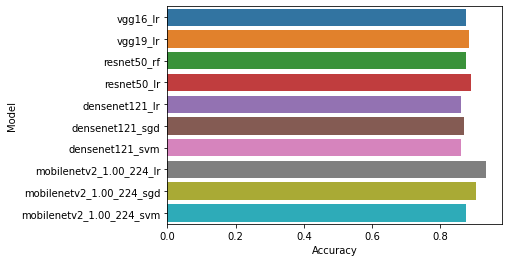

\begin{tabular}{lrrrrrrrr}
\toprule
                   Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
                vgg16\_lr &  0.875912 &   0.886792 & 0.810345 & 0.846847 & 0.867198 &     0.810345 &     0.924051 & 0.742908 \\
                vgg19\_lr &  0.883212 &   0.920000 & 0.793103 & 0.851852 & 0.871235 &     0.793103 &     0.949367 & 0.756336 \\
             resnet50\_rf &  0.875912 &   0.901961 & 0.793103 & 0.844037 & 0.864906 &     0.793103 &     0.936709 & 0.741710 \\
             resnet50\_lr &  0.890511 &   0.905660 & 0.827586 & 0.864865 & 0.882148 &     0.827586 &     0.936709 & 0.773154 \\
          densenet121\_lr &  0.861314 &   0.867925 & 0.793103 & 0.828829 & 0.852248 &     0.793103 &     0.911392 & 0.712661 \\
         densenet121\_sgd &  0.868613 &   0.844828 & 0.844828 & 0.844828 & 0.865452 &     0.844828 &     0.886076 & 0.730904 \\
         densenet121\_svm &  0.861314 &   0.882353 & 0.77586

In [ ]:
plot_performance()